IMD003
IMD009
IMD016
IMD022
IMD024
IMD025
IMD035
IMD038
IMD042
IMD044
IMD045
IMD050
IMD092
IMD101
IMD103
IMD112
IMD118
IMD125
IMD132
IMD134
IMD135
IMD144
IMD146
IMD147
IMD150
IMD152
IMD156
IMD159
IMD161
IMD162
IMD175
IMD177
IMD182
IMD198
IMD200
IMD010
IMD017
IMD020
IMD039
IMD041
IMD105
IMD107
IMD108
IMD133
IMD142
IMD143
IMD160
IMD173
IMD176
IMD196
IMD197
IMD199
IMD203
IMD204
IMD206
IMD207
IMD208
IMD364
IMD365
IMD367
IMD371
IMD372
IMD374
IMD375
IMD378
IMD379
IMD380
IMD381
IMD383
IMD384
IMD385
IMD389
IMD390
IMD392
IMD394
IMD395
IMD397
IMD399
IMD400
IMD402
IMD002
IMD004
IMD013
IMD015
IMD019
IMD021
IMD027
IMD030
IMD032
IMD033
IMD037
IMD040
IMD043
IMD047
IMD048
IMD049
IMD057
IMD075
IMD076
IMD078
IMD120
IMD126
IMD137
IMD138
IMD139
IMD140
IMD149
IMD153
IMD157
IMD164
IMD166
IMD169
IMD171
IMD210
IMD347
IMD155
IMD376
IMD006
IMD008
IMD014
IMD018
IMD023
IMD031
IMD036
IMD154
IMD170
IMD226
IMD243
IMD251
IMD254
IMD256
IMD278
IMD279
IMD280
IMD304
IMD305
IMD306
IMD312
IMD328
IMD331
IMD339
IMD356
IMD360

C:\Users\el295904\AppData\Local\Temp\ipykernel_16664\3335075041.py:82: RuntimeWarning: invalid value encountered in scalar divide
  score += np.sum(dataV) / len(dataV)
C:\Users\el295904\AppData\Local\Temp\ipykernel_16664\3335075041.py:81: RuntimeWarning: invalid value encountered in scalar divide
  score = np.sum(dataH) / len(dataH)


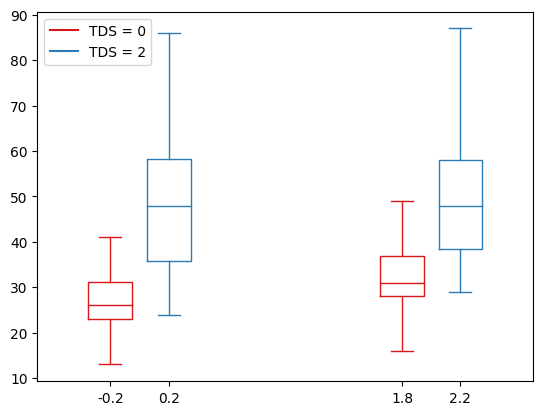

In [13]:
import importParent

from PIL import Image, ImageTk

import numpy as np
import cv2

from core.asymmetry import Asymmetry
from utils.cv import *
from utils.plot import draw_svm_boundries
from utils.xlrd import *

from dataset.load_PH2 import PH2

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.inspection import DecisionBoundaryDisplay
import pickle

import matplotlib.pyplot as plt
import seaborn as sns

import os

ph2 = PH2()
a = Asymmetry()

images_tk = ph2.load_images_tk()
images = ph2.load_images()
masks = ph2.load_masks()
ground = ph2.load_asymmetry()

masked = []
cropped_mask = []

def set_box_colour(bp, colour):
    plt.setp(bp['boxes'], color=colour)
    plt.setp(bp['whiskers'], color=colour)
    plt.setp(bp['caps'], color=colour)
    plt.setp(bp['medians'], color=colour)

#Crop the image to the white mask border in the image
for i in range(0, len(masks)):
    x, y, w, h = crop_mask(masks[i]) #converts to gray, finds non-zero pixels and returns x, y, w, and h
    cropped_mask.append(masks[i][y:y+h, x:x+w])
    cropped_img = images[i][y:y+h, x:x+w]

    element = apply_mask_cv(cropped_img, cropped_mask[i])
    masked.append(element)

    #cv2.imshow("Cropped", masked[i]) # Show it
    #cv2.waitKey(0)

tds0_mask = []
tds0_masked = []
tds1_mask = []
tds1_masked = []
tds2_mask = []
tds2_masked = []

for i in range(0, len(cropped_mask)):
    if ground[i] == 0:
        tds0_mask.append(cropped_mask[i])
        tds0_masked.append(masked[i])
    elif ground[i] == 1:
        tds1_mask.append(cropped_mask[i])
        tds1_masked.append(masked[i])
    elif ground[i] == 2:
        tds2_mask.append(cropped_mask[i])
        tds2_masked.append(masked[i])

def asymmetry_combined(tds_masked, tds_mask, compact):
    data = []
    dataX = []
    for i in range(0, len(tds_masked)):
        dataH, locH, dataV, locV, asymmetry = a.run(images[i], tds_masked[i], tds_mask[i], compactness=compact)
        data.append(asymmetry)
            
        score = np.sum(dataH) / len(dataH)
        score += np.sum(dataV) / len(dataV)

        #print(asymmetry)

        dataX.append(score)
        #dataX = np.append(dataX, dataH)

    return dataX

compactness = [20, 100]

asy_dict = {
    'sym': [],
    'asym': [],
}

for c in compactness:

    score0 = asymmetry_combined(tds0_masked, tds0_mask, c)
    #score1 = asymmetry_combined(tds1_masked, tds1_mask, c)
    score2 = asymmetry_combined(tds2_masked, tds2_mask, c)

    score0 = np.rint(score0)
    #score1 = np.rint(score1)
    score2 = np.rint(score2)

    score0 = score0[~np.isnan(score0)]
    #score1 = score1[~np.isnan(score1)]
    score2 = score2[~np.isnan(score2)]

    asy_dict['sym'].append(score0)
    asy_dict['asym'].append(score2)



#Get minimum, maximum, lower quartile, upper quartile, and median
ticks = ['A', 'B']

plt.figure()

bpl = plt.boxplot(asy_dict['sym'], positions=np.array(range(len(asy_dict['sym'])))*2.0-0.2, sym='', widths=0.3)

bpr = plt.boxplot(asy_dict['asym'], positions=np.array(range(len(asy_dict['asym'])))*2.0+0.2, sym='', widths=0.3)
    
set_box_colour(bpl, '#D7191C')
set_box_colour(bpr, '#2C7BB6')

plt.plot([], c='#D7191C', label='TDS = 0')
plt.plot([], c='#2C7BB6', label='TDS = 2')
plt.legend()

#plt.xticks(range(0, len(ticks) * 2, 2), ticks)
#plt.xlim(-2, len(ticks)*2)
#plt.ylim(0, 8)

plt.show()

#vertical_book = xlwt.Workbook()
#horiztonal_book = xlwt.Workbook()
#ground_book = xlwt.Workbook()
#save_output2d(dataX, 'Horizontal{j}', horiztonal_book)
#save_output2d(dataY, 'Vertical{j}', vertical_book)
#save_output1d(data, 'Results{j}', ground_book)
#vertical_book.save('vertical_output.xls')
#horiztonal_book.save('Horiztonal_output.xls')
#ground_book.save('ground_output.xls')